<a href="https://colab.research.google.com/github/srilamaiti/SM_MIDS_W207_HW/blob/main/w207_cancer_detection_sm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Cancer Detection***
## ***Applied Machine Learning W207 Final Project, Fall 2022***
### ***Members***
#### ***1. Chenyu Wang***
#### ***2. Hector Rincon***
#### ***3. Ifrah Javed***
#### ***4. Srila Maiti***

# ***A. Importing the Libraries***

In [1]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob
import random
from imutils import rotate as rotate
from itertools import product
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import cv2 as cv
import skimage.io as skio

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Mounted at /content/gdrive


In [2]:
tf.__version__

'2.8.2'

# ***B. File Processing***

### ***1. Downloading Image Files from Kaggle***

In [3]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [00:39<00:00, 111MB/s] 
100% 6.31G/6.31G [00:39<00:00, 173MB/s]


### ***2. Unzipping the Downaloaded Zip Files***

In [4]:
!unzip -o -qq \*.zip  && rm *.zip

### ***3. Data Validation and Spot Checks***

#### ***a. Train Files Count***

In [5]:
!ls -ltr /content/train/ |wc -l

220026


#### ***b. Validating record count of train_labels.csv with train file count***

In [6]:
!wc -l train_labels.csv

220026 train_labels.csv


#### ***c. Test Files Count***

In [7]:
!ls -ltr /content/test/ |wc -l

57459


#### ***d. Validating record count of sample_submission.csv with test file count***

In [8]:
!wc -l sample_submission.csv

57459 sample_submission.csv


#### ***e. Explore file structure of train_labels.csv***

In [9]:
!head train_labels.csv

id,label
f38a6374c348f90b587e046aac6079959adf3835,0
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
755db6279dae599ebb4d39a9123cce439965282d,0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
068aba587a4950175d04c680d38943fd488d6a9d,0
acfe80838488fae3c89bd21ade75be5c34e66be7,0
a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
559e55a64c9ba828f700e948f6886f4cea919261,0


#### ***f. Explore file structure of sample_submission.csv***

In [10]:
!head sample_submission.csv

id,label
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0
aa0307865281d4484ddf8c637c348292968b93a7,0
f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0
95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0


# ***C. Support Functionalities***

### ***1. Defining Parameters***

In [11]:
CONTRAST_FACTOR = 3
DELTA = 0.3

train_path = 'train/'
test_path = 'test/'

current_working_dir = os.getcwd()

train_label_file = 'train_labels.csv'
test_label_file = 'sample_submission.csv'

image_file_extension = '.tif'

train_files_path = os.path.join(current_working_dir, train_path)
test_files_path = os.path.join(current_working_dir, test_path)

# declare constants for reproduciblity
RANDOM_STATE = 20220922

# Finding split positions
split = (0.30, 0.10, 0.10)

process_chunk_size = 200

tf.random.set_seed(1234)
np.random.seed(1234)

### ***2. Generating Fully Qualified File Name List***
This function generates the list of fully qualified file name list based on the input parameter.

In [12]:
def generate_fully_qualified_file_name_list(file_list):
    """
    This function generates a list of fully qualified file names.
    """
    qualified_file_name_list = [os.path.join(current_working_dir, train_path) + 
                                img + 
                                '.tif' 
                                for img in file_list
                               ]
    return qualified_file_name_list

### ***3. Printing Images in Different Orientation***
This function prints the input imgae in different orientation.

In [13]:
def print_image_in_diff_orientation(image_file):
    """
    This function prints images.
    """
    tf.random.set_seed(1234)
    fig = plt.figure(figsize=(14, 12))
    #fig = plt.figure()
    image = skio.imread(image_file, plugin = "tifffile")
        
    # plot original
    ax = fig.add_subplot(1, 5, 1)
    ax.imshow(array_to_img(image))
    ax.set_title('Original', size=15);

    # resize
    ax = fig.add_subplot(1, 5, 2)
    img_resize = tf.image.resize(image, size=(224, 224))
    ax.imshow(array_to_img(img_resize))
    ax.set_title('Step 1: Resize', size=15);

    # adjust brightness
    ax = fig.add_subplot(1, 5, 3)
    img_bright = tf.image.adjust_brightness(img_resize, 0.3)
    ax.imshow(array_to_img(img_bright))
    ax.set_title('Step 2: Brightness', size=15);

    # adjust contrast
    ax = fig.add_subplot(1, 5, 4)
    img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
    ax.imshow(array_to_img(img_contrast))
    ax.set_title('Step 3: Contrast', size=15);

    # flip left right
    ax = fig.add_subplot(1, 5, 5)
    img_flip = tf.image.flip_left_right(img_contrast)
    ax.imshow(array_to_img(img_flip))
    ax.set_title('Step 4: Flip left right', size=15);

### ***4. Spliting Data in Train, Validation and Test Sets***
This function splits the input data set in train, validation and test data set based on the split indices.

In [14]:
def split_data(split_indices, df):
    """
    This function splits the input dataframe in train, validation and test set.
    """
    X_train = df[: split_indices[0]]
    X_val = df[split_indices[0] : split_indices[1]]
    X_test = df[split_indices[1]:]
    return X_train, X_val, X_test

### ***5. Get IDs and Labels for the Images***
This function gets id and label values for input train and test data set.

In [15]:
def get_id_and_label_list(file_path, file_extension):
    """
    This function gets the imgae id and corresponding label.
    """
    file_list = []
    for file_name in glob.glob(file_path + '*' + file_extension):
        file_list.append(file_name)
    return file_list

### ***6. Read Image File into a Numpy Array***
This function reads each image file in a Numpy array and returns it.

In [16]:
def read_image_file_in_np_array(image_list):
    """
    This function reads each image file in a Numpy array and returns it.
    """
    return np.asarray([skio.imread(image_file, plugin = "tifffile") for image_file in image_list])

### ***7. Converts Numpy Array to Tensor***
This function converts the numpy array representation of an image to a Tensor.

In [69]:
def convert_np_array_to_tensor(np_image_array):
    """
    This function converts the numpy array representation of each image in tensor.
    """
    return tf.convert_to_tensor(np_image_array, dtype = tf.float32)

### ***8. Converting Int Tensor to Float***
This function converts integer TF to Float.

In [18]:
def convert_int_tf_to_float(tf_image_list):
    """
    This function converts integer TF value to float.
    """
    return np.asanyarray([tf.cast(img, tf.float32) for img in tf_image_list])

### ***9. Converting to Grayscale***
This function converts color image to grayscale.

In [19]:
def convert_to_grayscale(tf_image_list):
    """
    This function converts color image to grayscale.
    """
    return tf.image.rgb_to_grayscale(tf_image_list) / 255.0

### ***10. Adjusting Brightness***
This function adjusts brightness of the images. 

In [20]:
def adjust_brightness(tf_image_list, delta):
    """
    This function adjusts the image brightness.
    """
    return tf.image.adjust_brightness(tf_image_list, delta = delta)

### ***11. Adjusting Contrast***
This function adjusts image contrast.

In [21]:
def adjust_contrast(tf_image_list, contrast_factor):
    """
    This function adjusts contrast of the image.
    """
    return tf.image.adjust_contrast(tf_image_list, contrast_factor = contrast_factor)

### ***12. Random Flip Left Right***
This function applies random flip to the image.

In [22]:
def random_flip_left_right(tf_image_list):
    """
    This function applies random flip to the image.
    """
    return tf.image.random_flip_left_right(tf_image_list)

### ***13. Rotate Images 90/180/270 Degrees***
This function rotates images 90/180/270 degrees.

In [23]:
def rotate_image(tf_image_list, k = 1):
    """
    This function rotates images by 90/180/270 degrees.
    k = 1 : 90 degree rotation
    k = 2 : 180 degree rotation
    k = 3 : 270 degree rotation
    """
    return tf.image.rot90(tf_image_list, k)

### ***14. Create Labels***
This function creates labels with 1 or 0.

In [24]:
def create_label(shape, label = 1):
    """
    This function creates labels.
    """
    if label == 1:
        return np.ones(shape).flatten()
    elif label == 0:
        return np.zeros(shape).flatten()

# ***D. Collecting File Information***

### ***1. Get the Image IDs and Corresponding Labels***

There are 220,025 and 57,458 train and test images respectively(tiff 
extension). Each image is 96 X 96 color images (with 3 channels). We are also given train_labels.csv and sample_submission.csv which contain label information for train and test images respectively.

In [25]:
#get file names for train and test
train_file_list = []
test_file_list = []

train_file_list = get_id_and_label_list(train_files_path, image_file_extension)
test_file_list = get_id_and_label_list(test_files_path, image_file_extension)

train_label = pd.read_csv(train_label_file)
test_label = pd.read_csv(test_label_file)

print(f"Number of train files : {len(train_file_list)}")
print(f"Number of train files : {len(test_file_list)}")

Number of train files : 220025
Number of train files : 57458


### ***2. Checking for Duplicate IDs***

In [26]:
df_train_id_count = pd.DataFrame(train_label.groupby(['id'])['id'].count())
df_train_id_count.columns = ['id_count']
df_train_id_count.reset_index(inplace = True)
print("Number of train duplicate entries : ", len(df_train_id_count[df_train_id_count.id_count > 1]))

df_test_id_count = pd.DataFrame(test_label.groupby(['id'])['id'].count())
df_test_id_count.columns = ['id_count']
df_test_id_count.reset_index(inplace = True)
print("Number of test duplicate entries : ", len(df_test_id_count[df_test_id_count.id_count > 1]))

Number of train duplicate entries :  0
Number of test duplicate entries :  0


### ***3. Seperating Postive and Negative Images from the Training Data***

In [27]:
train_positive_image_id_list = list(train_label[train_label.label==1].id)
train_negative_image_id_list = list(train_label[train_label.label==0].id)

train_positive_images_list = generate_fully_qualified_file_name_list(train_positive_image_id_list)
train_negative_images_list = generate_fully_qualified_file_name_list(train_negative_image_id_list)

print(f"Number of positive images in train set: {len(train_positive_images_list)}")
print(f"Number of negative images in train set: {len(train_negative_images_list)}")

Number of positive images in train set: 89117
Number of negative images in train set: 130908


# ***E. Exploratory Data Visualization***

### ***1. Count Distribution of Train Data***

Text(0.5, 1.0, 'Train Data label Count')

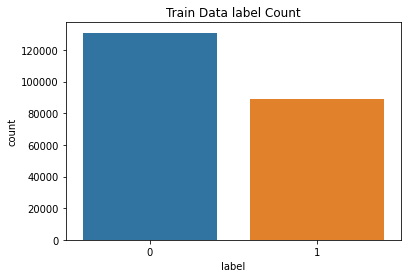

In [28]:
sns.countplot(data = train_label, x = 'label')
plt.title("Train Data label Count")

### ***2. Train Label Percentage Pie Chart***

In [29]:
fig = px.pie(train_label, 
             values = train_label['label'].value_counts().values, 
             names = train_label['label'].unique())
fig.update_layout(
    title={
        'text': "Train Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### ***3. Count Distribution of Test Data***

Text(0.5, 1.0, 'Test Data label Count')

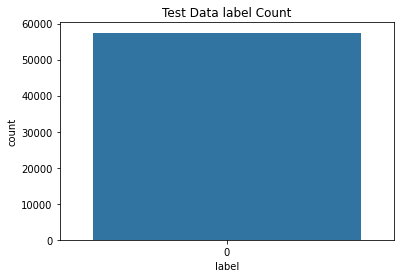

In [30]:
sns.countplot(data = test_label, x = 'label')
plt.title("Test Data label Count")

### ***4. Train Label Percentage Pie Chart***

In [31]:
fig = px.pie(test_label, 
             values = test_label['label'].value_counts().values, 
             names = test_label['label'].unique())
fig.update_layout(
    title={
        'text': "Test Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### ***5. Printing Positive Images (Cancer Present) in Different Orientation***

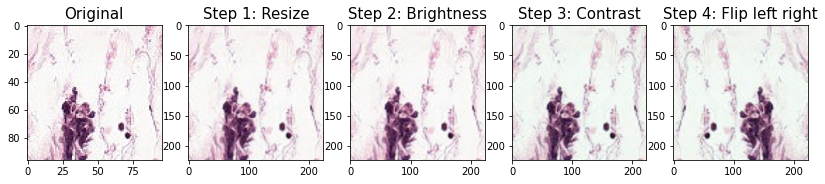

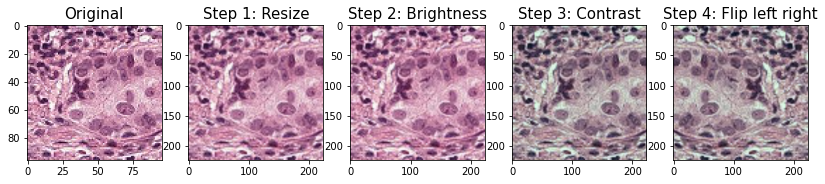

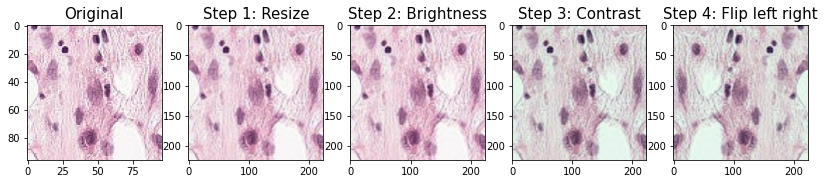

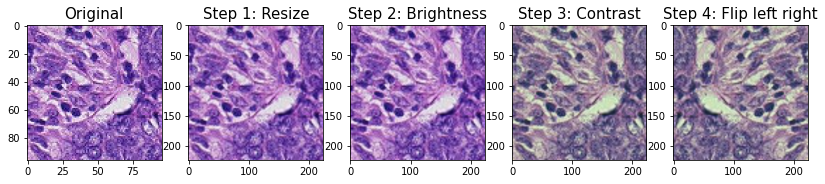

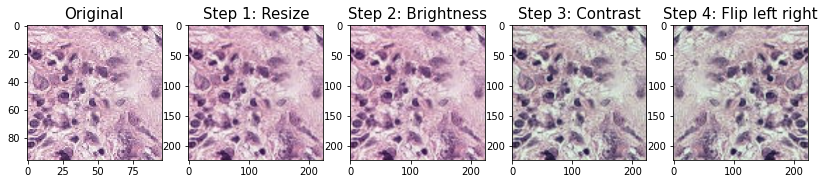

In [32]:
for image in train_positive_images_list[:5]:
    print_image_in_diff_orientation(image)

### ***6. Printing Negative Images (No Cancer) in Different Orientation***

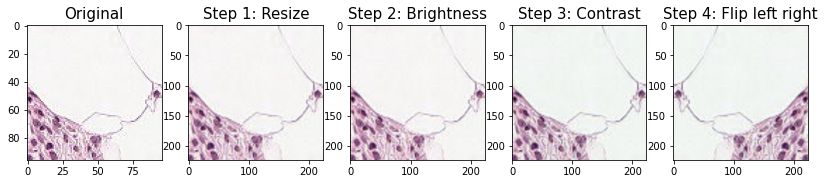

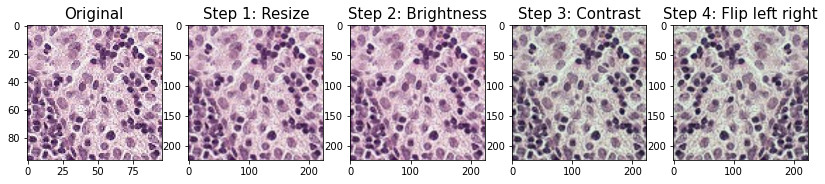

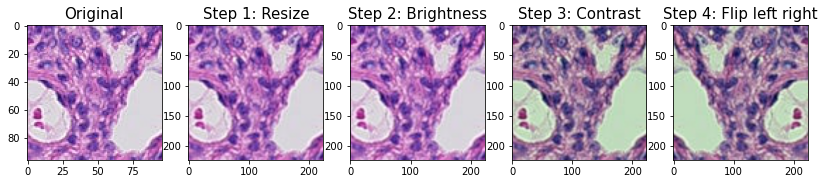

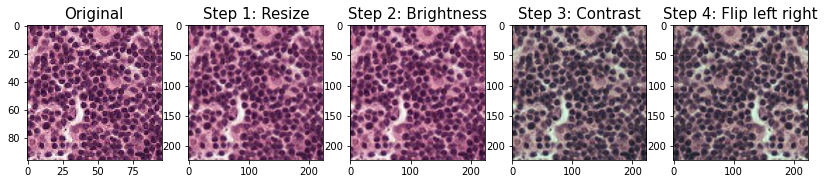

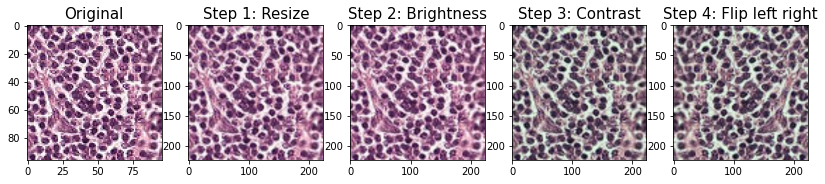

In [33]:
for image in train_negative_images_list[:5]:
    print_image_in_diff_orientation(image)

In [34]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/temp/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
training_datagen

# ***F. Considerations*** 
### ***1. We see an imbalance between positive and negative images.***
We will consider equal number of positive and negative images for training and test data. 
### ***2. We do not have correct label for test data.***
We will repurpose part of train data for testing.

# ***G. Data Preprocessing***

### ***1. Shuffling Data***

In [35]:
# Shuffling data
shuffled_train_label = shuffle(train_label)
len_shuffled_train_label = len(shuffled_train_label)

# Selecting positive and negative images from the shuffled list
shuffled_train_positive_label_df = shuffled_train_label[shuffled_train_label.label == 1]
shuffled_train_negative_label_df = shuffled_train_label[shuffled_train_label.label == 0]

print(f"Length of shuffled_train_positive_label_df : {len(shuffled_train_positive_label_df)}")
print(f"Length of shuffled_train_negative_label_df : {len(shuffled_train_negative_label_df)}")

Length of shuffled_train_positive_label_df : 89117
Length of shuffled_train_negative_label_df : 130908


### ***2. Obtaining Split Indices***

In [36]:
split_indices = np.multiply(len(shuffled_train_positive_label_df), split).astype(int)
for idx, val in enumerate(split_indices):
    #print(idx, val)
    if idx > 0:
        split_indices[idx] = sum(split_indices[idx - 1 : idx]) + split_indices[idx]
print("Split indecs : ", split_indices)

Split indecs :  [26735 35646 44557]


### ***3. Spliting Data in Train(60%), Validation(20%) and Test(20%) Sets for Both Positive and Negative Images.***
To handle data imbalance problem, we will use equal number of positive and negative images. Thus, we will use 30% train positive, 30% train negative, 10% validation postive, 10% validation negative, 10% test positive and 10% test negative images.

In [37]:
# Splitting data at train, validation and test positions 
# for both positive and negative imgaes
# This process will select the list of ids
(X_train_id_positive, 
 X_val_id_positive, 
 X_test_id_positive) = split_data(split_indices = split_indices, 
                                  df = shuffled_train_positive_label_df[:split_indices[-1]]
                                 )
(X_train_id_negative, 
 X_val_id_negative, 
 X_test_id_negative) = split_data(split_indices = split_indices, 
                                  df = shuffled_train_negative_label_df[:split_indices[-1]]
                                 )
 
print(f"Length of X_train_id_positive : {len(X_train_id_positive)}")
print(f"Length of X_train_id_negative : {len(X_train_id_negative)}")

print(f"Length of X_val_id_positive : {len(X_val_id_positive)}")
print(f"Length of X_val_id_negative : {len(X_val_id_negative)}")

print(f"Length of X_test_id_positive : {len(X_test_id_positive)}")
print(f"Length of X_test_id_negative : {len(X_test_id_negative)}")

Length of X_train_id_positive : 26735
Length of X_train_id_negative : 26735
Length of X_val_id_positive : 8911
Length of X_val_id_negative : 8911
Length of X_test_id_positive : 8911
Length of X_test_id_negative : 8911


### ***4. Generating Fully Qualified Image File Name List for Both Positive and Negative Images***

In [38]:
X_train_img_file_positive = generate_fully_qualified_file_name_list(list(np.concatenate(X_train_id_positive[['id']].values.tolist()).flat))
X_val_img_file_positive = generate_fully_qualified_file_name_list(list(np.concatenate(X_val_id_positive[['id']].values.tolist()).flat))
X_test_img_file_positive = generate_fully_qualified_file_name_list(list(np.concatenate(X_test_id_positive[['id']].values.tolist()).flat))

X_train_img_file_negative = generate_fully_qualified_file_name_list(list(np.concatenate(X_train_id_negative[['id']].values.tolist()).flat))
X_val_img_file_negative = generate_fully_qualified_file_name_list(list(np.concatenate(X_val_id_negative[['id']].values.tolist()).flat))
X_test_img_file_negative = generate_fully_qualified_file_name_list(list(np.concatenate(X_test_id_negative[['id']].values.tolist()).flat))

print(f"Length of X_train_img_file_positive : {len(X_train_img_file_positive)}")
print(f"Length of X_train_img_file_negative : {len(X_train_img_file_negative)}")

print(f"Length of X_val_img_file_positive : {len(X_val_img_file_positive)}")
print(f"Length of X_val_img_file_negative : {len(X_val_img_file_negative)}")

print(f"Length of X_test_img_file_positive : {len(X_test_img_file_positive)}")
print(f"Length of X_test_img_file_negative : {len(X_test_img_file_negative)}")

Length of X_train_img_file_positive : 26735
Length of X_train_img_file_negative : 26735
Length of X_val_img_file_positive : 8911
Length of X_val_img_file_negative : 8911
Length of X_test_img_file_positive : 8911
Length of X_test_img_file_negative : 8911


### ***5. Reading Image File in Numpy Array***

In [39]:
# This process will read each image file and store them in np array
# for both positive and negative images
X_train_positive_np = read_image_file_in_np_array(X_train_img_file_positive)
X_val_positive_np = read_image_file_in_np_array(X_val_img_file_positive)
X_test_positive_np = read_image_file_in_np_array(X_test_img_file_positive)

X_train_negative_np = read_image_file_in_np_array(X_train_img_file_negative)
X_val_negative_np = read_image_file_in_np_array(X_val_img_file_negative)
X_test_negative_np = read_image_file_in_np_array(X_test_img_file_negative)

print(f"Length of X_train_positive_np : {len(X_train_positive_np)}")
print(f"Length of X_train_negative_np : {len(X_train_negative_np)}")

print(f"Length of X_val_positive_np : {len(X_val_positive_np)}")
print(f"Length of X_val_negative_np : {len(X_val_negative_np)}")

print(f"Length of X_test_positive_np : {len(X_test_positive_np)}")
print(f"Length of X_test_negative_np : {len(X_test_negative_np)}")

Length of X_train_positive_np : 26735
Length of X_train_negative_np : 26735
Length of X_val_positive_np : 8911
Length of X_val_negative_np : 8911
Length of X_test_positive_np : 8911
Length of X_test_negative_np : 8911


### ***6. Converting Numpy Array to Tensor***

In [77]:
# This process converts np array to tensor
# for both positive and negative images
X_train_positive_tf = convert_np_array_to_tensor(X_train_positive_np)
X_val_positive_tf = convert_np_array_to_tensor(X_val_positive_np)
X_test_positive_tf = convert_np_array_to_tensor(X_test_positive_np)

X_train_negative_tf = convert_np_array_to_tensor(X_train_negative_np)
X_val_negative_tf = convert_np_array_to_tensor(X_val_negative_np)
X_test_negative_tf = convert_np_array_to_tensor(X_test_negative_np)

print(f"Length of X_train_positive_tf : {len(X_train_positive_tf)}")
print(f"Length of X_train_negative_tf : {len(X_train_negative_tf)}")

print(f"Length of X_val_positive_tf : {len(X_val_positive_tf)}")
print(f"Length of X_val_negative_tf : {len(X_val_negative_tf)}")

print(f"Length of X_test_positive_tf : {len(X_test_positive_tf)}")
print(f"Length of X_test_negative_tf : {len(X_test_negative_tf)}")

Length of X_train_positive_tf : 26735
Length of X_train_negative_tf : 26735
Length of X_val_positive_tf : 8911
Length of X_val_negative_tf : 8911
Length of X_test_positive_tf : 8911
Length of X_test_negative_tf : 8911


### ***7. Creating Labels***

#### ***a. Creating Positive Labels***

In [52]:
Y_train_positive = create_label(len(X_train_positive_tf))
Y_val_positive = create_label(len(X_val_positive_tf))
Y_test_positive = create_label(len(X_test_positive_tf))

#### ***b. Creating Negative Labels***

In [53]:
Y_train_negative = create_label(len(X_train_negative_tf), 0)
Y_val_negative = create_label(len(X_val_negative_tf), 0)
Y_test_negative = create_label(len(X_test_negative_tf), 0)

# ***H. Image Processing***

### ***1. Converting Color Images to Grayscale***

In [78]:
print("Handling grayscale conversion for X_train_positive_tf")
X_train_positive_tf = convert_to_grayscale(X_train_positive_tf)
gc.collect()
tf.keras.backend.clear_session()

print("Handling grayscale conversion for X_val_positive_tf")
X_val_positive_tf = convert_to_grayscale(X_val_positive_tf)
gc.collect()
tf.keras.backend.clear_session()

print("Handling grayscale conversion for X_test_positive_tf")
X_test_positive_tf = convert_to_grayscale(X_test_positive_tf)
gc.collect()
tf.keras.backend.clear_session()

print("Handling grayscale conversion for X_train_negative_tf")
X_train_negative_tf = convert_to_grayscale(X_train_negative_tf)
gc.collect()
tf.keras.backend.clear_session()

print("Handling grayscale conversion for X_val_negative_tf")
X_val_negative_tf = convert_to_grayscale(X_val_negative_tf)
gc.collect()
tf.keras.backend.clear_session()

print("Handling grayscale conversion for X_test_negative_tf")
X_test_negative_tf = convert_to_grayscale(X_test_negative_tf)
gc.collect()
tf.keras.backend.clear_session()

print(f"Length of X_train_positive_tf : {len(X_train_positive_tf)}")
print(f"Length of X_train_negative_tf : {len(X_train_negative_tf)}")

print(f"Length of X_val_positive_tf : {len(X_val_positive_tf)}")
print(f"Length of X_val_negative_tf : {len(X_val_negative_tf)}")

print(f"Length of X_test_positive_tf : {len(X_test_positive_tf)}")
print(f"Length of X_test_negative_tf : {len(X_test_negative_tf)}")

Handling grayscale conversion for X_train_positive_tf
Handling grayscale conversion for X_val_positive_tf
Handling grayscale conversion for X_test_positive_tf
Handling grayscale conversion for X_train_negative_tf
Handling grayscale conversion for X_val_negative_tf
Handling grayscale conversion for X_test_negative_tf
Length of X_train_positive_tf : 26735
Length of X_train_negative_tf : 26735
Length of X_val_positive_tf : 8911
Length of X_val_negative_tf : 8911
Length of X_test_positive_tf : 8911
Length of X_test_negative_tf : 8911


### ***2. Adjusting Brightness of the Images***

In [79]:
print("Handling brightness adjustment for X_train_positive_tf")
aug_adj_brghtnss_X_train_positive_tf = adjust_brightness(X_train_positive_tf, delta = DELTA)
aug_adj_brghtnss_Y_train_positive = create_label(len(aug_adj_brghtnss_X_train_positive_tf))
gc.collect()
tf.keras.backend.clear_session()

print("Handling brightness adjustment for X_train_negative_tf")
aug_adj_brghtnss_X_train_negative_tf = adjust_brightness(X_train_negative_tf, delta=DELTA)
aug_adj_brghtnss_Y_train_negative = create_label(len(aug_adj_brghtnss_X_train_negative_tf), 0)
gc.collect()
tf.keras.backend.clear_session()

print(f"Length of aug_adj_brghtnss_X_train_positive_tf : {len(aug_adj_brghtnss_X_train_positive_tf)}")
print(f"Length of aug_adj_brghtnss_X_train_negative_tf : {len(aug_adj_brghtnss_X_train_negative_tf)}")

print(f"Length of aug_adj_brghtnss_Y_train_positive : {len(aug_adj_brghtnss_Y_train_positive)}")
print(f"Length of aug_adj_brghtnss_Y_train_negative : {len(aug_adj_brghtnss_Y_train_negative)}")

Handling brightness adjustment for X_train_positive_tf
Handling brightness adjustment for X_train_negative_tf
Length of aug_adj_brghtnss_X_train_positive_tf : 26735
Length of aug_adj_brghtnss_X_train_negative_tf : 26735
Length of aug_adj_brghtnss_Y_train_positive : 26735
Length of aug_adj_brghtnss_Y_train_negative : 26735


### ***3. Adjusting Contrast of the Images***

In [80]:
print("Handling contrast adjustment for X_train_positive_tf")
aug_adj_cntrst_X_train_positive_tf = adjust_contrast(X_train_positive_tf, contrast_factor = CONTRAST_FACTOR)
aug_adj_cntrst_Y_train_positive = create_label(len(aug_adj_cntrst_X_train_positive_tf))
gc.collect()
tf.keras.backend.clear_session()

print("Handling contrast adjustment for X_train_negative_tf")
aug_adj_cntrst_X_train_negative_tf = adjust_contrast(X_train_negative_tf, contrast_factor = CONTRAST_FACTOR)
aug_adj_cntrst_Y_train_negative = create_label(len(aug_adj_cntrst_X_train_negative_tf), 0)
gc.collect()
tf.keras.backend.clear_session()

print(f"Length of aug_adj_cntrst_X_train_positive_tf : {len(aug_adj_cntrst_X_train_positive_tf)}")
print(f"Length of aug_adj_cntrst_X_train_negative_tf : {len(aug_adj_cntrst_X_train_negative_tf)}")

print(f"Length of aug_adj_cntrst_Y_train_positive : {len(aug_adj_cntrst_Y_train_positive)}")
print(f"Length of aug_adj_cntrst_Y_train_negative : {len(aug_adj_cntrst_Y_train_negative)}")

Handling contrast adjustment for X_train_positive_tf
Handling contrast adjustment for X_train_negative_tf
Length of aug_adj_cntrst_X_train_positive_tf : 26735
Length of aug_adj_cntrst_X_train_negative_tf : 26735
Length of aug_adj_cntrst_Y_train_positive : 26735
Length of aug_adj_cntrst_Y_train_negative : 26735


### ***4. Random Flip***

In [81]:
print("Handling random flip for X_train_positive_tf")
aug_rnd_flip_X_train_positive_tf = random_flip_left_right(X_train_positive_tf)
aug_rnd_flip_Y_train_positive = create_label(len(aug_rnd_flip_X_train_positive_tf))
gc.collect()
tf.keras.backend.clear_session()

print("Handling random flip for X_train_negative_tf")
aug_rnd_flip_X_train_negative_tf = random_flip_left_right(X_train_negative_tf)
aug_rnd_flip_Y_train_negative = create_label(len(aug_rnd_flip_X_train_negative_tf), 0)
gc.collect()
tf.keras.backend.clear_session()

print(f"Length of aug_rnd_flip_X_train_positive_tf : {len(aug_rnd_flip_X_train_positive_tf)}")
print(f"Length of aug_rnd_flip_X_train_negative_tf : {len(aug_rnd_flip_X_train_negative_tf)}")

print(f"Length of aug_rnd_flip_Y_train_positive : {len(aug_rnd_flip_Y_train_positive)}")
print(f"Length of aug_rnd_flip_Y_train_negative : {len(aug_rnd_flip_Y_train_negative)}")

Handling random flip for X_train_positive_tf
Handling random flip for X_train_negative_tf
Length of aug_rnd_flip_X_train_positive_tf : 26735
Length of aug_rnd_flip_X_train_negative_tf : 26735
Length of aug_rnd_flip_Y_train_positive : 26735
Length of aug_rnd_flip_Y_train_negative : 26735


### ***5. Rotate***

#### ***a. Rotate Images by 90 degrees***

In [82]:
print("Handling image rotation by 90 degrees for X_train_positive_tf")
aug_rot_90_X_train_positive_tf = rotate_image(X_train_positive_tf)
aug_rot_90_Y_train_positive = create_label(len(aug_rot_90_X_train_positive_tf))
gc.collect()
tf.keras.backend.clear_session()

print("Handling image rotation by 90 degrees for X_train_negative_tf")
aug_rot_90_X_train_negative_tf = rotate_image(X_train_negative_tf)
aug_rot_90_Y_train_negative = create_label(len(aug_rot_90_X_train_negative_tf), 0)
gc.collect()
tf.keras.backend.clear_session()

print(f"Length of aug_rot_90_X_train_positive_tf : {len(aug_rot_90_X_train_positive_tf)}")
print(f"Length of aug_rot_90_X_train_negative_tf : {len(aug_rot_90_X_train_negative_tf)}")

print(f"Length of aug_rot_90_Y_train_positive : {len(aug_rot_90_Y_train_positive)}")
print(f"Length of aug_rot_90_Y_train_negative : {len(aug_rot_90_Y_train_negative)}")

Handling image rotation by 90 degrees for X_train_positive_tf
Handling image rotation by 90 degrees for X_train_negative_tf
Length of aug_rot_90_X_train_positive_tf : 26735
Length of aug_rot_90_X_train_negative_tf : 26735
Length of aug_rot_90_Y_train_positive : 26735
Length of aug_rot_90_Y_train_negative : 26735


#### ***b. Rotate Images by 180 degrees***

In [83]:
print("Handling image rotation by 180 degrees for X_train_positive_tf")
aug_rot_180_X_train_positive_tf = rotate_image(X_train_positive_tf, k = 2)
aug_rot_180_Y_train_positive = create_label(len(aug_rot_180_X_train_positive_tf))
gc.collect()
tf.keras.backend.clear_session()

print("Handling image rotation by 180 degrees for X_train_negative_tf")
aug_rot_180_X_train_negative_tf = rotate_image(X_train_negative_tf, k = 2)
aug_rot_180_Y_train_negative = create_label(len(aug_rot_180_X_train_negative_tf), 0)
gc.collect()
tf.keras.backend.clear_session()

print(f"Length of aug_rot_180_X_train_positive_tf : {len(aug_rot_180_X_train_positive_tf)}")
print(f"Length of aug_rot_180_X_train_negative_tf : {len(aug_rot_180_X_train_negative_tf)}")

print(f"Length of aug_rot_180_Y_train_positive : {len(aug_rot_180_Y_train_positive)}")
print(f"Length of aug_rot_180_Y_train_negative : {len(aug_rot_180_Y_train_negative)}")

Handling image rotation by 180 degrees for X_train_positive_tf
Handling image rotation by 180 degrees for X_train_negative_tf
Length of aug_rot_180_X_train_positive_tf : 26735
Length of aug_rot_180_X_train_negative_tf : 26735
Length of aug_rot_180_Y_train_positive : 26735
Length of aug_rot_180_Y_train_negative : 26735


#### ***c. Rotate Images by 270 degrees***

In [84]:
print("Handling image rotation by 270 degrees for X_train_positive_tf")
aug_rot_270_X_train_positive_tf = rotate_image(X_train_positive_tf, k = 3)
aug_rot_270_Y_train_positive = create_label(len(aug_rot_270_X_train_positive_tf))
gc.collect()
tf.keras.backend.clear_session()

print("Handling image rotation by 270 degrees for X_train_negative_tf")
aug_rot_270_X_train_negative_tf = rotate_image(X_train_negative_tf, k = 3)
aug_rot_270_Y_train_negative = create_label(len(aug_rot_270_X_train_negative_tf), 0)
gc.collect()
tf.keras.backend.clear_session()

print(f"Length of aug_rot_270_X_train_positive_tf : {len(aug_rot_270_X_train_positive_tf)}")
print(f"Length of aug_rot_270_X_train_negative_tf : {len(aug_rot_270_X_train_negative_tf)}")

print(f"Length of aug_rot_270_Y_train_positive : {len(aug_rot_270_Y_train_positive)}")
print(f"Length of aug_rot_270_Y_train_negative : {len(aug_rot_270_Y_train_negative)}")

Handling image rotation by 270 degrees for X_train_positive_tf
Handling image rotation by 270 degrees for X_train_negative_tf
Length of aug_rot_270_X_train_positive_tf : 26735
Length of aug_rot_270_X_train_negative_tf : 26735
Length of aug_rot_270_Y_train_positive : 26735
Length of aug_rot_270_Y_train_negative : 26735


### ***6. Adding Back the Augmented Images***

In [85]:
X_train_positive_tf = tf.concat([X_train_positive_tf 
                              , aug_adj_brghtnss_X_train_positive_tf
                              , aug_rnd_flip_X_train_positive_tf
                              , aug_adj_cntrst_X_train_positive_tf
                              , aug_rot_90_X_train_positive_tf
                              , aug_rot_180_X_train_positive_tf
                              , aug_rot_270_X_train_positive_tf
                                ] 
                              , axis = 0
                              )

X_train_negative_tf = tf.concat([X_train_negative_tf 
                              , aug_adj_brghtnss_X_train_negative_tf
                              , aug_rnd_flip_X_train_negative_tf
                              , aug_adj_cntrst_X_train_negative_tf
                              , aug_rot_90_X_train_negative_tf
                              , aug_rot_180_X_train_negative_tf
                              , aug_rot_270_X_train_negative_tf
                                ] 
                              , axis = 0
                              )
Y_train_positive_tf = tf.concat([Y_train_positive
                              , aug_adj_brghtnss_Y_train_positive
                              , aug_rnd_flip_Y_train_positive
                              , aug_adj_cntrst_Y_train_positive
                              , aug_rot_90_Y_train_positive
                              , aug_rot_180_Y_train_positive
                              , aug_rot_270_Y_train_positive
                                ] 
                              , axis = 0
                              )

Y_train_negative_tf = tf.concat([Y_train_negative
                              , aug_adj_brghtnss_Y_train_negative
                              , aug_rnd_flip_Y_train_negative
                              , aug_adj_cntrst_Y_train_negative
                              , aug_rot_90_Y_train_negative
                              , aug_rot_180_Y_train_negative
                              , aug_rot_270_Y_train_negative
                                ] 
                              , axis = 0
                              )

print(f"X_train_positive_tf shape: {X_train_positive_tf.shape}")
print(f"Y_train_positive_tf shape: {len(Y_train_positive_tf)}")

print(f"X_train_negative_tf shape: {X_train_negative_tf.shape}")
print(f"Y_train_negative_tf shape: {len(Y_train_negative_tf)}")

print(f"X_val_positive_tf shape: {X_val_positive_tf.shape}")
print(f"Y_val_positive shape: {len(Y_val_positive)}")

print(f"X_val_negative_tf shape: {X_val_negative_tf.shape}")
print(f"Y_val_negative shape: {len(Y_val_negative)}")

print(f"X_test_positive_tf shape: {X_test_positive_tf.shape}")
print(f"Y_test_positive shape: {len(Y_test_positive)}")

print(f"X_test_negative_tf shape: {X_test_negative_tf.shape}")
print(f"Y_test_negative shape: {len(Y_test_negative)}")

### ***7. Shuffling Back the Data***